a

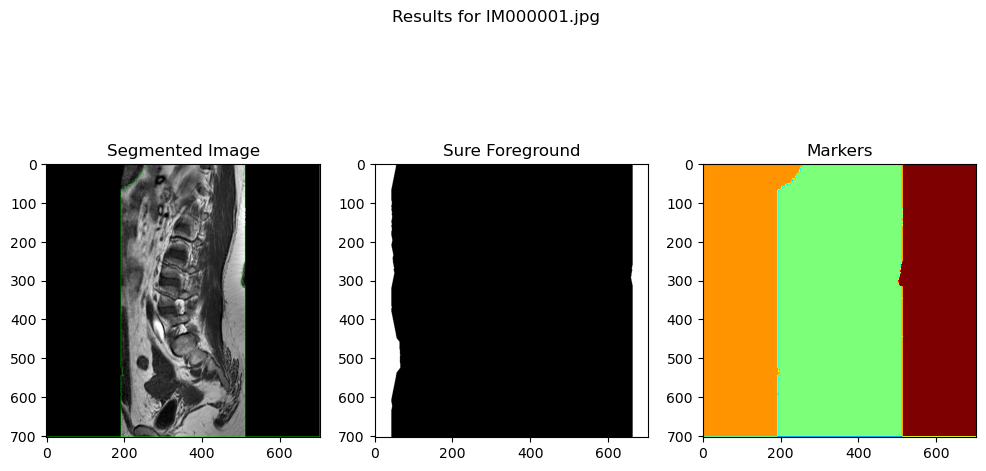

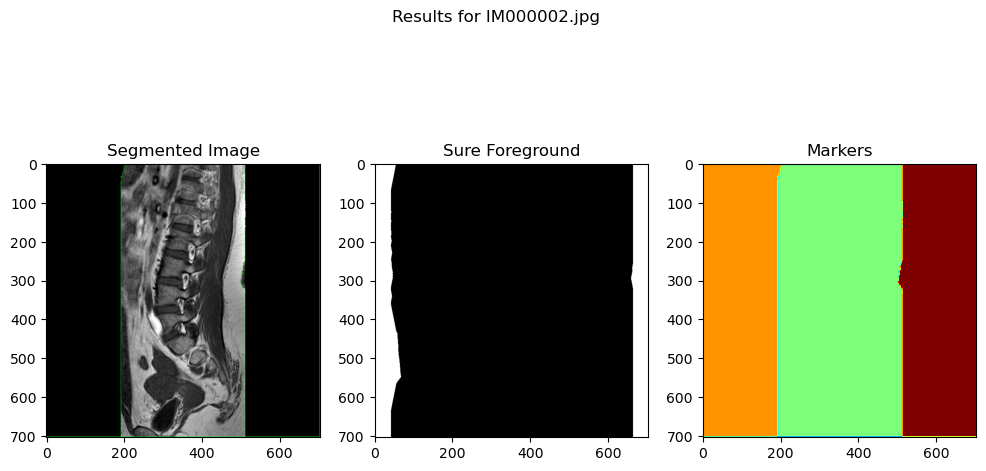

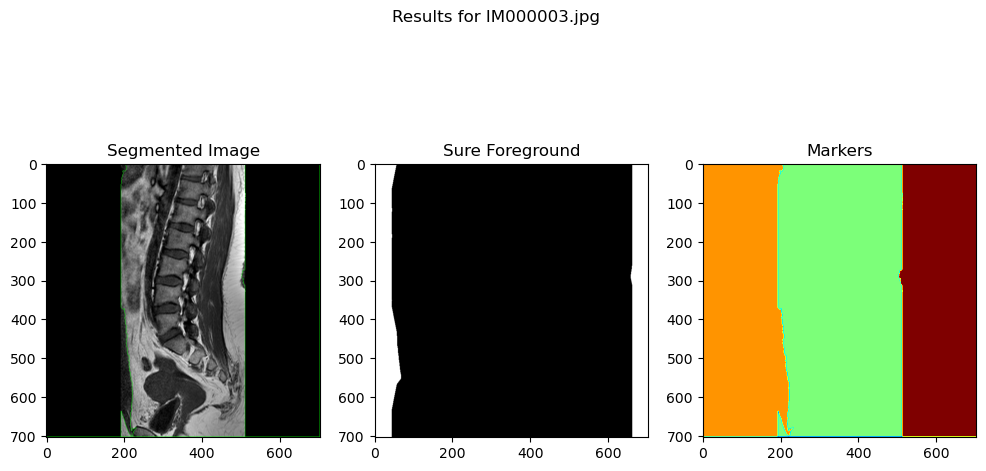

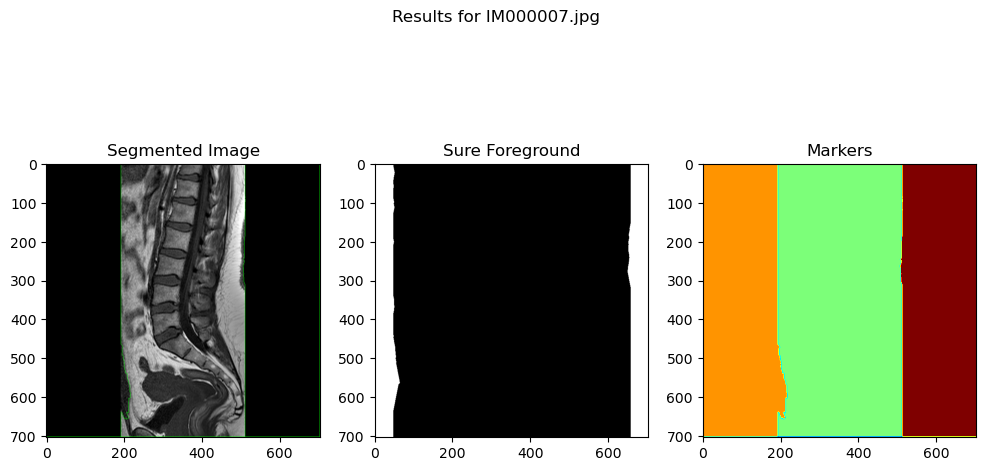

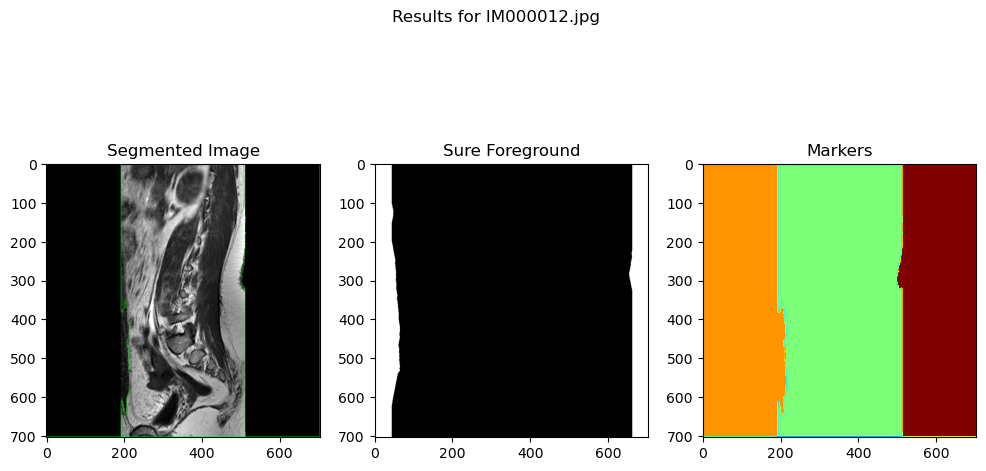

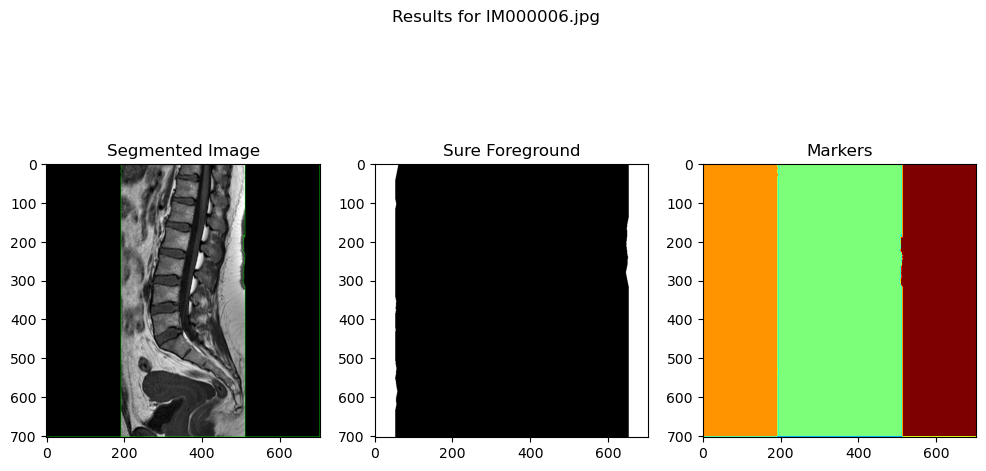

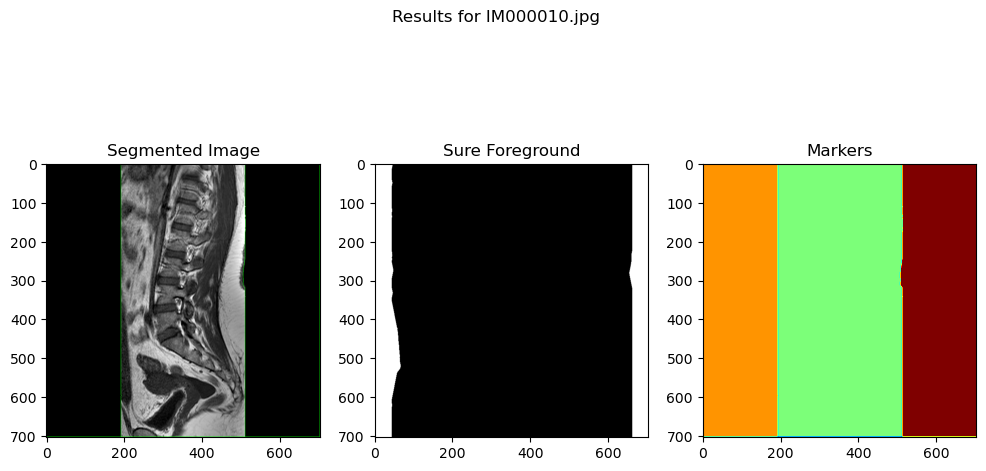

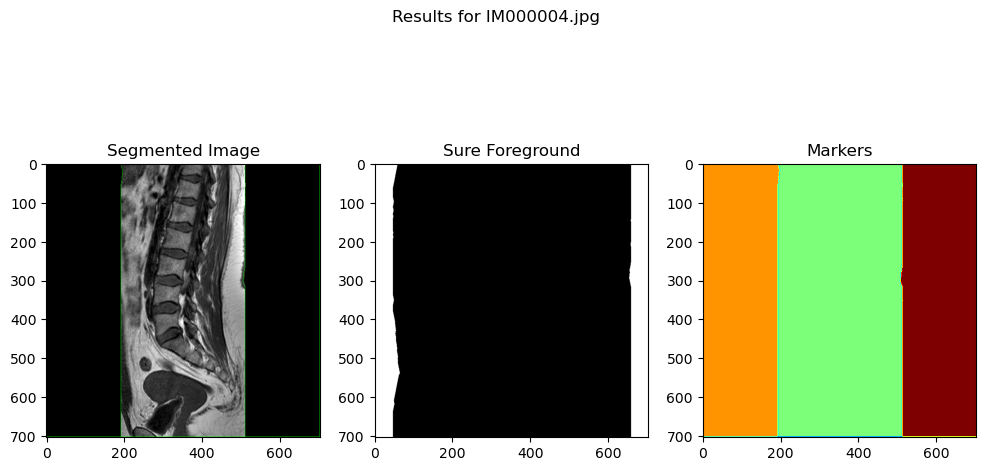

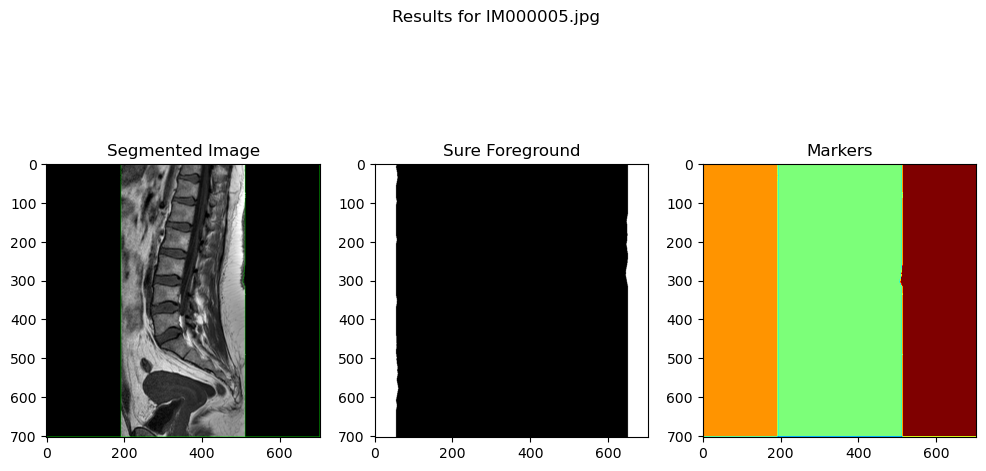

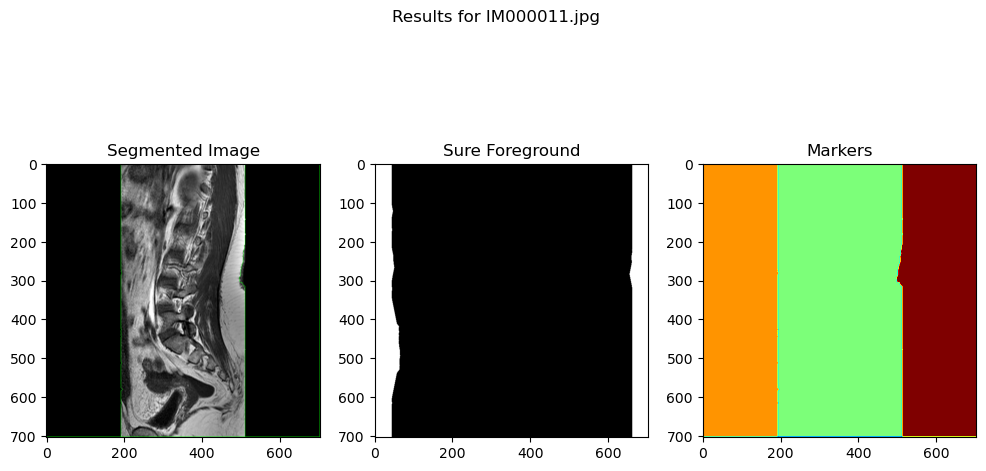

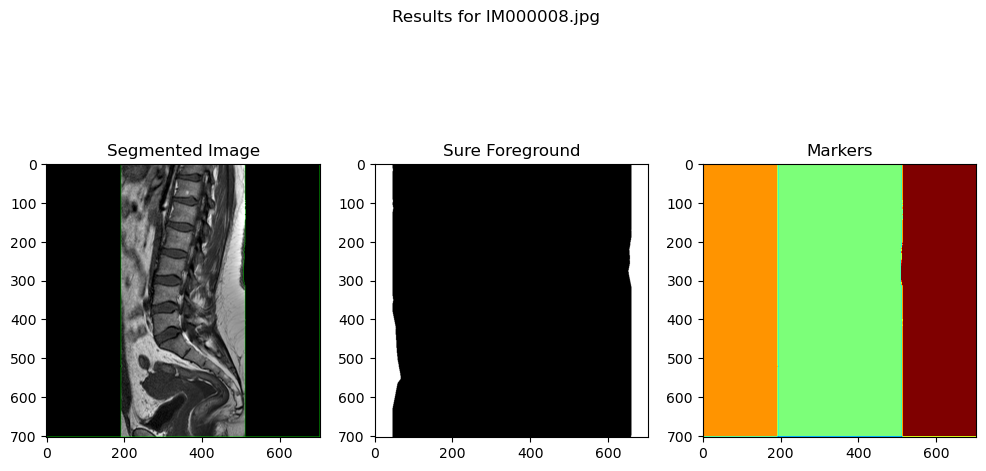

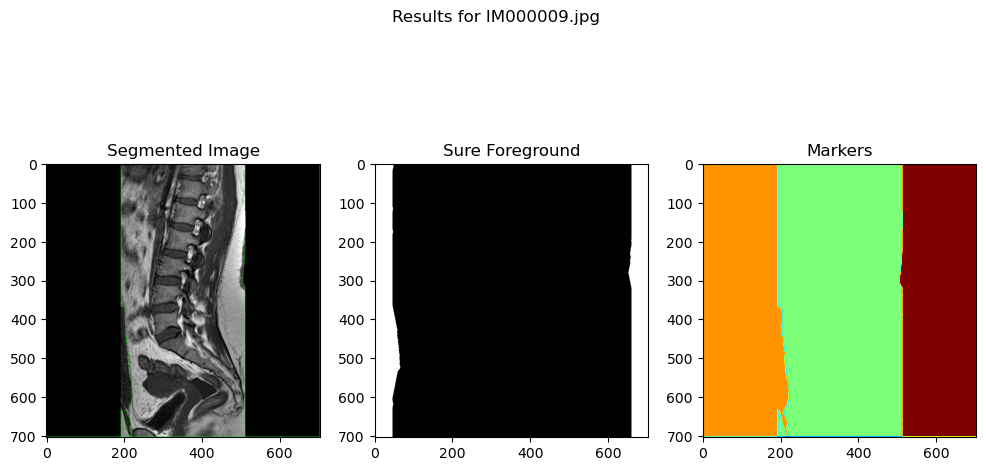

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Folder path
folder_path = '/Users/abubakr/Downloads/Project Astra/Data/Spinal_MRI/ST000001/new'

# Loop through all image files
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        
        if image is None:
            print(f"Failed to load {filename}")
            continue
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        kernel = np.ones((3, 3), np.uint8)
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
        sure_bg = cv2.dilate(opening, kernel, iterations=3)

        dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
        ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
        sure_fg = sure_fg.astype(np.uint8)
        unknown = cv2.subtract(sure_bg, sure_fg)

        ret, markers = cv2.connectedComponents(sure_fg)
        markers += 1
        markers[unknown == 255] = 0

        markers = cv2.watershed(image, markers)
        image[markers == -1] = [0, 255, 0]  # green boundary

        # Display results
        plt.figure(figsize=(12, 6))
        plt.suptitle(f"Results for {filename}")
        plt.subplot(131), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Segmented Image')
        plt.subplot(132), plt.imshow(sure_fg, cmap='gray'), plt.title('Sure Foreground')
        plt.subplot(133), plt.imshow(markers, cmap='jet'), plt.title('Markers')
        plt.show()



In [3]:
# Convert sure foreground to binary
contours, _ = cv2.findContours(sure_fg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    if perimeter == 0:
        continue
    circularity = 4 * np.pi * area / (perimeter ** 2)
    
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = float(w) / h

    print(f"File: {filename}")
    print(f" - Area: {area:.2f}")
    print(f" - Circularity: {circularity:.2f}")
    print(f" - Aspect Ratio: {aspect_ratio:.2f}")

    # Rule-based abnormality detection (customizable)
    if area < 500 or circularity < 0.6:
        print(" --> 🔴 Possible abnormal region detected")
    else:
        print(" --> 🟢 Likely normal")


File: IM000009.jpg
 - Area: 31346.00
 - Circularity: 0.17
 - Aspect Ratio: 0.08
 --> 🔴 Possible abnormal region detected
File: IM000009.jpg
 - Area: 33573.50
 - Circularity: 0.18
 - Aspect Ratio: 0.09
 --> 🔴 Possible abnormal region detected
